In [1]:
import iminuit
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

import CohesiveCrack
import DataProcessor

In [2]:
Gamma = 0.21  # Fracture energy (J/m^2)
E = 51e9      # Young's modulus (Pa)
nu = 0.25     # Poisson's ratio
C_f = 2404    # Rupture speed (m/s)
C_s = 2760    # Shear wave speed (m/s)
C_d = 4790    # Longitudinal wave speed (m/s)

In [3]:
filename = '../Data/p5979e.npz'

In [4]:
data = np.load(filename, allow_pickle = True)
data = data["experiment"][()]
event = data['runs'][2]['events'][2]
exy6 = event['strain']['original']['raw'][6]


TIME_S = event['strain']['original']['time']
C_f = np.abs(event['rupture_speed'])
print(C_f)
print(type(C_f))

fs = len(TIME_S) / (np.max(TIME_S) - np.min(TIME_S))
print(f'Sampling rate: {fs:.1f}Hz')

DISTANCE = TIME_S * C_f * 1000 # mm


STRAIN = DataProcessor.voltage_to_strain(exy6)
STRESS = DataProcessor.shear_strain_to_stress(E, nu, STRAIN)
STRESS = STRESS - STRESS[0]
STRESS_MPA = STRESS / 10**6
STRESS_MPA *= -1

1074.6268403037348
<class 'numpy.float64'>
Sampling rate: 100000.2Hz


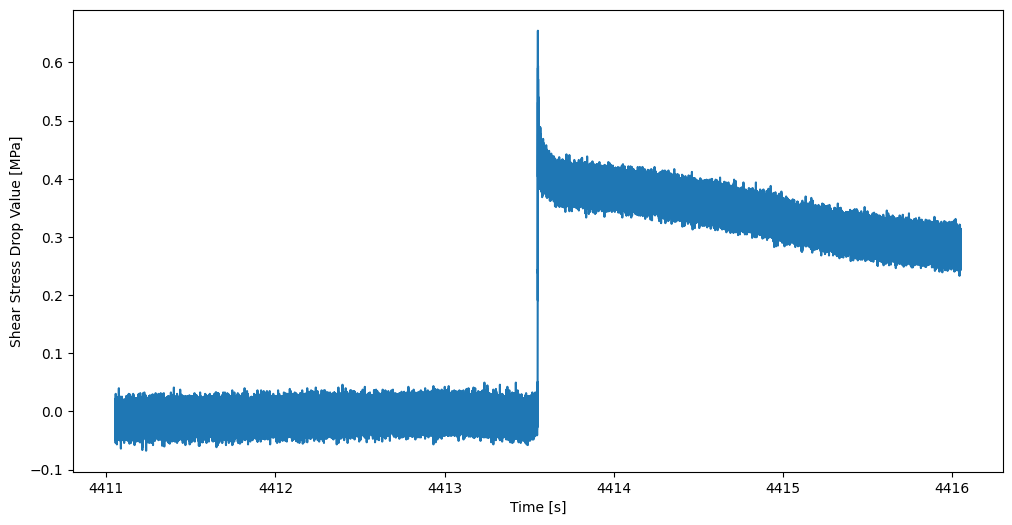

In [5]:
plt.figure(figsize = (12, 6))

plt.plot(TIME_S, STRESS_MPA, label=r'$\epsilon_{xy}$')
plt.xlabel('Time [s]')
plt.ylabel('Shear Stress Drop Value [MPa]')
# plt.plot(event['strain']['original']['time'], eyy6 - eyy6[0], label=r'$\epsilon_{yy}$')
plt.savefig('../Plot/p5979_test1.pdf', dpi = 300)
plt.show()

In [6]:
cutoff = 100
FILTERED_STRESS_MPA = DataProcessor.highpass_filter(STRESS_MPA, cutoff, fs)

In [7]:
hspan = 2000


# STA, LTA window length
sta_window = 40   # STA window length
lta_window = 300  # LTA window length

# Calculate STA, LTA by convolution
sta = np.convolve(FILTERED_STRESS_MPA**2, np.ones(sta_window)/sta_window, mode='valid')
lta = np.convolve(FILTERED_STRESS_MPA**2, np.ones(lta_window)/lta_window, mode='valid')

# Matching STA and LTA data length
min_length = min(len(sta), len(lta))
sta = sta[:min_length]
lta = lta[:min_length]

# Calculate LTA/STA ratio
lta_sta_ratio = sta / lta

# Find peak and peak's index
max_ratio = np.max(lta_sta_ratio)
max_index = np.argmax(lta_sta_ratio)

In [8]:
start_index = max_index - 120
end_index   = max_index + 120

CUT_STRESS_MPA = STRESS_MPA[start_index:end_index]
LOCAL_PEAKS, _ = scipy.signal.find_peaks(CUT_STRESS_MPA, prominence = 0.02, distance = 30)
GLOBAL_PEAKS = LOCAL_PEAKS + start_index

GLOBAL_PEAK = GLOBAL_PEAKS[4]

print(f'Peaks: {GLOBAL_PEAK}')
print(f'Peak Values: {STRESS_MPA[GLOBAL_PEAK]}')

Peaks: 249989
Peak Values: 0.6545521709479429


In [9]:
DISTANCE = DISTANCE - DISTANCE[GLOBAL_PEAK]

Best fit A: 1733.358
Best fit B: 12157.962


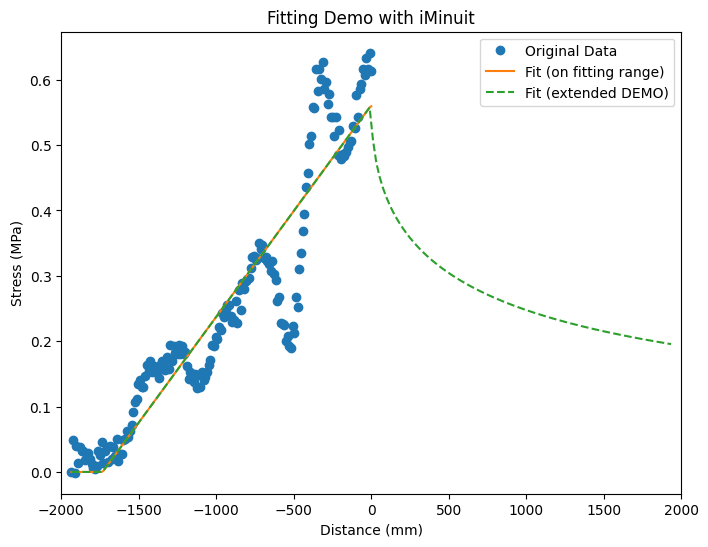

In [10]:
# 假設 DataProcessor 為你所使用的模組
# 並且其中有一個 fitting_function(A, C_f, B, distance, some_value) 可以呼叫
# from your_module import DataProcessor

# ------------------------------------------------------------------------
# (1) 建立要做 fitting 的資料
# ------------------------------------------------------------------------
# 假設你已經有 STRESS_MPA, GLOBAL_PEAK, fs, C_f 等參數
# 這裡僅示範如何取資料與做 fitting，請自行根據實際程式補齊

STRESS_MPA_FOR_FIT = STRESS_MPA[GLOBAL_PEAK - 180: GLOBAL_PEAK]
STRESS_MPA_FOR_FIT = STRESS_MPA_FOR_FIT - STRESS_MPA_FOR_FIT[0]  # shift 到 0

DISTANCE_FOR_FIT = np.linspace(-180, 0, 180) / fs * C_f * 1000  # mm
DISTANCE_FOR_DEMO = np.linspace(-180, 180, 180) / fs * C_f * 1000  # mm

# ------------------------------------------------------------------------
# (2) 定義 chi-square function
# ------------------------------------------------------------------------
def chi_square(A, B):
    """
    A, B 為待擬合參數 (問題中你說2000, 20000是要做 fitting 的目標)
    其他參數 (C_f, 8e-3) 在此先寫死或從外部取得
    """
    # 產生模型預測值 (單位 MPA)
    # 注意 fitting_function 回傳可能是 Pa (?), 這裡做 /10**6 轉為 MPa
    # 請確保跟你的程式單位一致
    model = DataProcessor.fitting_function(A, C_f, B, DISTANCE_FOR_FIT, 8e-3) / 10**6
    
    # 簡單起見，假設誤差全部為 1，也可以用你真實量測得到的誤差
    # chi2 = sum( (data_i - model_i)^2 / sigma_i^2 )
    chi2 = np.sum((STRESS_MPA_FOR_FIT - model)**2)
    return chi2

# ------------------------------------------------------------------------
# (3) 利用 iminuit 尋找 chi-square 最小值
# ------------------------------------------------------------------------
# 初始值給你一開始猜的 2000, 20000
m = iminuit.Minuit(chi_square, A=2000, B=20000)

# errordef = 1 對應到 Least-Squares / Chi-square
m.errordef = 1

# 執行擬合
m.migrad()

# 拿出最佳擬合參數
Xc_fit = m.values["A"]
Gamma_fit = m.values["B"]

print(f"Best fit A: {Xc_fit:.3f}")
print(f"Best fit B: {Gamma_fit:.3f}")

# ------------------------------------------------------------------------
# (4) 繪圖：比較原始資料和 fit 結果
# ------------------------------------------------------------------------
# 0) Setup Figure
plt.figure(figsize = (8, 6))

# 1) 原始資料 (只到 0, 共 180 點)
plt.plot(DISTANCE_FOR_FIT, STRESS_MPA_FOR_FIT, "o", label="Original Data")

# 2) 最佳擬合後，示範如何畫出「對應 DISTANCE_FOR_FIT」的擬合曲線
STRESS_MPA_FIT_CURVE = DataProcessor.fitting_function(Xc_fit, C_f, Gamma_fit, DISTANCE_FOR_FIT, 8e-3) / 10**6
plt.plot(DISTANCE_FOR_FIT, STRESS_MPA_FIT_CURVE, "-", label="Fit (on fitting range)")

# 3) 若想擴大範圍 (對應 DISTANCE_FOR_DEMO)
STRESS_MPA_FOR_DEMO = DataProcessor.fitting_function(Xc_fit, C_f, Gamma_fit, DISTANCE_FOR_DEMO, 8e-3) / 10**6
plt.plot(DISTANCE_FOR_DEMO, STRESS_MPA_FOR_DEMO, "--", label="Fit (extended DEMO)")

# 設定 x, y 範圍
plt.xlim(-2000, 2000)
plt.xlabel("Distance (mm)")
plt.ylabel("Stress (MPa)")
plt.legend()
plt.title("Fitting Demo with iMinuit")
plt.show()
plt.close()

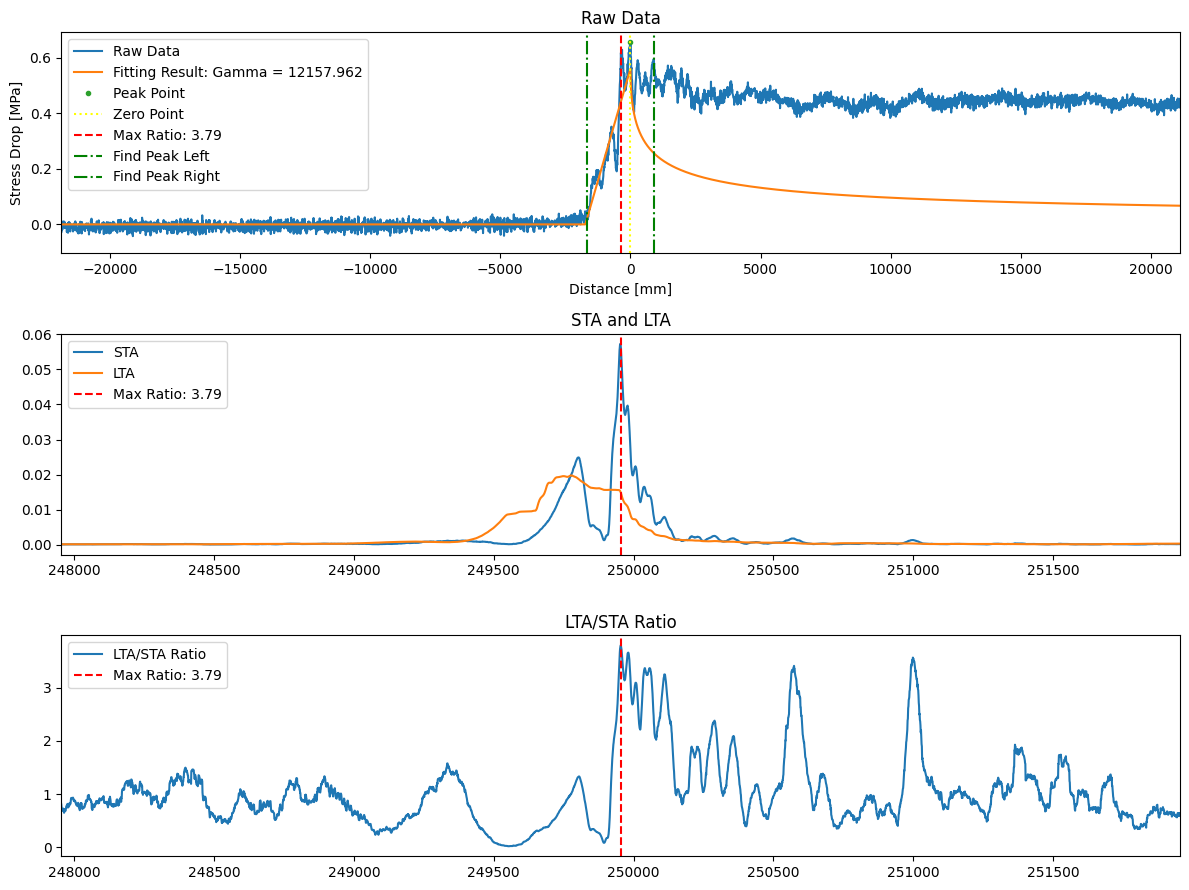

In [11]:
plt.figure(figsize = (12, 9))

# Plot raw data (No filter)
plt.subplot(3, 1, 1)
plt.plot(DISTANCE, STRESS_MPA, label = 'Raw Data')

plt.plot(DISTANCE, DataProcessor.fitting_function(Xc_fit, C_f, Gamma_fit, DISTANCE, 8e-3) / 10**6, label = f'Fitting Result: Gamma = {Gamma_fit:.3f}')


plt.plot(DISTANCE[GLOBAL_PEAK], STRESS_MPA[GLOBAL_PEAK], '.', label = 'Peak Point')
plt.xlabel('Distance [mm]')
plt.ylabel('Stress Drop [MPa]')
plt.axvline(x = DISTANCE[GLOBAL_PEAK], color = 'yellow', linestyle = ':', label = 'Zero Point')
plt.axvline(x = DISTANCE[max_index], color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.axvline(x = DISTANCE[max_index - 120], color = 'green', linestyle = '-.', label = f'Find Peak Left')
plt.axvline(x = DISTANCE[max_index + 120], color = 'green', linestyle = '-.', label = f'Find Peak Right')
plt.xlim(DISTANCE[max_index - hspan], DISTANCE[max_index + hspan])
plt.title('Raw Data')
plt.legend(loc = 'upper left')

# Plot STA, LTA
plt.subplot(3, 1, 2)
plt.plot(sta, label = 'STA')
plt.plot(lta, label = 'LTA')
plt.axvline(x = max_index, color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.xlim(max_index - hspan, max_index + hspan)
plt.title('STA and LTA')
plt.legend(loc = 'upper left')

# Plot LTA/STA ratio
plt.subplot(3, 1, 3)
plt.plot(lta_sta_ratio, label='LTA/STA Ratio')
plt.axvline(x = max_index, color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.xlim(max_index - hspan, max_index + hspan)
plt.title('LTA/STA Ratio')
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.savefig('../Plot/STA-LTA-5979-test.pdf')
plt.show()
plt.close()